# <p style="text-align: center; font-style: strong;">Soft-NMS</p>
### <p style="text-align: center;">(Almond: 0.7.0, Scala: 2.12.8)</p>


## Dependencies

In [1]:
interp.load.ivy(coursierapi.Dependency.of("org.platanios", "tensorflow_2.12", "0.4.1").withClassifier("darwin-cpu-x86_64"))

In [15]:
import org.tensorflow.framework.GraphDef
import org.platanios.tensorflow.api.ops.{ Files, Image => TImage }
import org.platanios.tensorflow.api.core.client.{ FeedMap, Session }
import org.platanios.tensorflow.api.core.{ Graph, Shape, NewAxis }
import org.platanios.tensorflow.api.{ UByte, tf, Tensor, --- }
import java.io.{BufferedInputStream, File, FileInputStream}
import scala.io.Source
import scala.collection.mutable.ListBuffer
import scala.math.{min, max, exp, sqrt, abs}

import org.tensorflow.framework.GraphDef

import org.platanios.tensorflow.api.ops.{ Files, Image => TImage }

import org.platanios.tensorflow.api.core.client.{ FeedMap, Session }

import org.platanios.tensorflow.api.core.{ Graph, Shape, NewAxis }

import org.platanios.tensorflow.api.{ UByte, tf, Tensor, --- }

import java.io.{BufferedInputStream, File, FileInputStream}

import scala.io.Source

import scala.collection.mutable.ListBuffer

import scala.math.{min, max, exp, sqrt, abs}

## Initialization
Just modify *modelsFileName* and *imageName* and after respect the following project structure :

```
data    
└───labelsMap
   │   X.txt
   │   Y.txt
└───models
   │   X.pb
   │   Y.pb   
images
│   Z.txt
```


In [3]:
val basedir = "data"
val imageName = "0049.png"
val modelsFileName = List("coco", "kitti")
val imageFilePath = s"${System.getProperty("user.dir")}/images/${imageName}"

val labelsMapPath = modelsFileName.map(name => s"${System.getProperty("user.dir")}/${basedir}/labelsMap/${name}.txt")
val modelsGraphPath = modelsFileName.map(name => s"${System.getProperty("user.dir")}/${basedir}/models/${name}.pb")

basedir: String = "data"
imageName: String = "0049.png"
modelsFileName: List[String] = List("coco", "kitti")
imageFilePath: String = "/Users/vincentbrule/Desktop/notebook_project/notebookExamples/softNMS/images/0049.png"
labelsMapPath: List[String] = List(
  "/Users/vincentbrule/Desktop/notebook_project/notebookExamples/softNMS/data/labelsMap/coco.txt",
  "/Users/vincentbrule/Desktop/notebook_project/notebookExamples/softNMS/data/labelsMap/kitti.txt"
)
modelsGraphPath: List[String] = List(
  "/Users/vincentbrule/Desktop/notebook_project/notebookExamples/softNMS/data/models/coco.pb",
  "/Users/vincentbrule/Desktop/notebook_project/notebookExamples/softNMS/data/models/kitti.pb"
)

In [5]:
lazy val graphs = modelsGraphPath.map(model => Graph.fromGraphDef(GraphDef.parseFrom(new BufferedInputStream(new FileInputStream(new File(model))))))

graphs: List[Graph] = List(
  org.platanios.tensorflow.api.core.Graph@30a92c9,
  org.platanios.tensorflow.api.core.Graph@3b54c89
)

In [7]:
val sessions = graphs.map(Session(_))
val sessionSimple = Session()

sessions: List[Session] = List(
  org.platanios.tensorflow.api.core.client.Session@67031934,
  org.platanios.tensorflow.api.core.client.Session@786e473b
)
sessionSimple: Session = org.platanios.tensorflow.api.core.client.Session@7db244d

## Prepare recuperation of graph results

In [8]:
val placeholdersOutput = graphs.map { graph => 
    Map("detectionBoxes" -> graph.getOutputByName("detection_boxes:0").toFloat,
        "detectionScores" -> graph.getOutputByName("detection_scores:0").toFloat,
        "detectionClasses" -> graph.getOutputByName("detection_classes:0").toFloat,
        "numDetections" -> graph.getOutputByName("num_detections:0").toFloat)
}

val placeholdersImage = graphs.map(_.getOutputByName("image_tensor:0").toUByte)

placeholdersOutput: List[Map[String, org.platanios.tensorflow.api.ops.Output[Float]]] = List(
  Map(
    "detectionBoxes" -> Output(detection_boxes, 0),
    "detectionScores" -> Output(detection_scores, 0),
    "detectionClasses" -> Output(detection_classes, 0),
    "numDetections" -> Output(num_detections, 0)
  ),
  Map(
    "detectionBoxes" -> Output(detection_boxes, 0),
    "detectionScores" -> Output(detection_scores, 0),
    "detectionClasses" -> Output(detection_classes, 0),
    "numDetections" -> Output(num_detections, 0)
  )
)
placeholdersImage: List[org.platanios.tensorflow.api.ops.Output[UByte]] = List(
  Output(image_tensor, 0),
  Output(image_tensor, 0)
)

## Open and transform image

In [10]:
val (imgTensor, fileNamePlaceholder) = tf.createWith() {
    val fileNamePlaceholder = tf.placeholder[String]()
    val fileTensor = Files.readFile(fileNamePlaceholder)
    val imgTensor = TImage.decodePng(fileTensor, 3)
    (imgTensor, fileNamePlaceholder)
  }

imgTensor: org.platanios.tensorflow.api.ops.Output[UByte] = Output(DecodePng, 0)
fileNamePlaceholder: org.platanios.tensorflow.api.ops.Output[String] = Output(
  Placeholder,
  0
)

In [13]:
val imageOuts = tf.createWith() {
    val file = new File(imageFilePath)
    val fileNameTensor = Tensor.fill(Shape())(file.getAbsolutePath())
    val feedImg = FeedMap(Map(fileNamePlaceholder -> fileNameTensor))
    sessionSimple.run(fetches = imgTensor, feeds = feedImg)
}

imageOuts: Tensor[UByte] = Tensor[UByte, [960, 1280, 3]]

In [16]:
val listFeeds = placeholdersImage.map(placeholder => FeedMap(Map(placeholder -> imageOuts.slice(NewAxis, ---))))


listFeeds: List[FeedMap] = List(
  org.platanios.tensorflow.api.core.client.FeedMap@76d1f846,
  org.platanios.tensorflow.api.core.client.FeedMap@278b9d5e
)

## Read labelsMap file and transform it into Scala Map

In [17]:
val labelsMapToString = labelsMapPath.map { path => 
    Source.fromFile(path).getLines.map { line =>
        val splitLine = line.split(" ")
        splitLine(0).toInt -> splitLine(1)
    }.toMap
}

labelsMapToString: List[Map[Int, String]] = List(
  Map(
    88 -> "teddy",
    5 -> "airplane",
    10 -> "traffic",
    56 -> "broccoli",
    42 -> "surfboard",
    24 -> "zebra",
    37 -> "sports",
    25 -> "giraffe",
    52 -> "banana",
    14 -> "parking",
    20 -> "sheep",
    46 -> "wine",
    57 -> "carrot",
    78 -> "microwave",
    84 -> "book",
    61 -> "cake",
    89 -> "hair",
    1 -> "person",
    74 -> "mouse",
    6 -> "bus",
    60 -> "donut",
    85 -> "clock",
    28 -> "umbrella",
    38 -> "kite",
    70 -> "toilet",
    21 -> "cow",
    33 -> "suitcase",
    65 -> "bed",
    9 -> "boat",
    53 -> "apple",
    77 -> "cell",
    13 -> "stop",
    41 -> "skateboard",
    73 -> "laptop",
    2 -> "bicycle",
    32 -> "tie",
    34 -> "frisbee",
...

## Detection 

In [18]:
val threshold = 0.5 // Thereshold to discard detection below that
val height = imageOuts.shape(0)
val width = imageOuts.shape(1)
val sigma = 0.5

threshold: Double = 0.5
height: Int = 960
width: Int = 1280
sigma: Double = 0.5

*boxes* = Positions of object detected

*score* = Confidence for each detection

*classes* = number corresponding to a class inside our labelMap previously defined

*num* = Number of detection

In [19]:
val detections = sessions.zipWithIndex.map { case (s, index) =>
      s.run(
        fetches =
          Seq(placeholdersOutput(index)("detectionBoxes"), placeholdersOutput(index)("detectionScores"), placeholdersOutput(index)("detectionClasses"), placeholdersOutput(index)("numDetections")),
          feeds = listFeeds(index))
}

detections: List[org.platanios.tensorflow.api.implicits.helpers.OutputToTensor.<refinement>.this.type.V] = List(
  List(
    Tensor[Float, [1, 100, 4]],
    Tensor[Float, [1, 100]],
    Tensor[Float, [1, 100]],
    Tensor[Float, [1]]
  ),
  List(
    Tensor[Float, [1, 100, 4]],
    Tensor[Float, [1, 100]],
    Tensor[Float, [1, 100]],
    Tensor[Float, [1]]
  )
)

## Boxes filter

In [20]:
// Use relative positions to be able to draw bounding box after
val listTabBoxes = detections.zipWithIndex.map { case (detection, index) => 
    for {
        i <- 0 until detection(3).scalar.toInt
        labelId = detection(2)(0, i).toFloat.scalar.toInt
        box = detection(0)(0, i).toFloat.entriesIterator.toSeq
        y1 = (box(0))
        x1 = (box(1))
        y2 = (box(2))
        x2 = (box(3))
        labelBox = List(y1, x1, y2, x2)
        score = detection(1)(0, i).toFloat.scalar
  } yield (labelsMapToString(index)(labelId), score, labelBox)
}

listTabBoxes: List[collection.immutable.IndexedSeq[(String, Float, List[Float])]] = List(
  Vector(
    ("car", 0.9794971F, List(0.4935566F, 0.47661132F, 0.6014528F, 0.5672374F)),
    (
      "person",
      0.95856625F,
      List(0.47492397F, 0.110764265F, 0.59637415F, 0.13835679F)
    ),
    (
      "car",
      0.90885586F,
      List(0.50398344F, 0.36453286F, 0.5631795F, 0.47467276F)
    ),
    ("car", 0.90802795F, List(0.5093983F, 0.58895814F, 0.56805617F, 0.6453989F)),
    ("car", 0.7555205F, List(0.5193226F, 0.9017174F, 0.5718531F, 0.9454131F)),
    ("car", 0.52926576F, List(0.5127777F, 0.94346535F, 0.59766036F, 1.0F)),
    (
      "parking",
      0.42517924F,
      List(0.5135686F, 0.19312058F, 0.6041481F, 0.222146F)
    )
  ),
  Vector(
    ("car", 1.0F, List(0.49448112F, 0.4810094F, 0.6017109F, 0.5743151F)),
    ("car", 0.99995637F, List(0.5065034F, 0.5870256F, 0.5681555F, 0.64949447F))
  )
)

## Scala boxes to Tensorflow boxes

In [21]:
// We start by keep only positions and flatMap all boxes and transform it into Tensor
val listFlatBoxes = listTabBoxes.map { tabBoxesFiltered => Tensor(tabBoxesFiltered.flatMap{ case(_, _, positions) => positions }) }
// We reshape it to have shape like : [batch, num_bounding_boxes, 4]
val listTensorWithAllBoxes = listFlatBoxes.map { tensorFlatBoxes => tf.reshape(tensorFlatBoxes, Shape(1, tensorFlatBoxes.shape(1) / 4, 4)) }


listFlatBoxes: List[Tensor[Float]] = List(
  Tensor[Float, [1, 28]],
  Tensor[Float, [1, 8]]
)
listTensorWithAllBoxes: List[org.platanios.tensorflow.api.ops.Output[Float]] = List(
  Output(Reshape, 0),
  Output(Reshape_1, 0)
)

In [22]:
// We combined detections boxes from all models
val boxesCombined = Tensor(listTabBoxes.flatMap {boxes => boxes.flatMap { case(_, _, positions) => positions } })
// We obtain a Tensor with Shape [1, num_all_boxes, 4]
val tensorBoxesCombined = tf.reshape(boxesCombined, Shape(1, listTabBoxes.foldLeft(0) { (acc, i) => acc + i.length }, 4))

boxesCombined: Tensor[Float] = Tensor[Float, [1, 36]]
tensorBoxesCombined: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  Reshape_2,
  0
)

## Display results

In [23]:
// list with image + detection boxes for each model
val listImageToDisplay = listTensorWithAllBoxes.map { tensorWithAllBoxes =>
    tf.reshape(TImage.drawBoundingBoxes(imageOuts.slice(NewAxis, ---).toFloat, tensorWithAllBoxes).toUByte, Shape(height, width, 3))
}

// image with all boxes
val imageCombinedToDisplay = tf.reshape(TImage.drawBoundingBoxes(imageOuts.slice(NewAxis, ---).toFloat, tensorBoxesCombined).toUByte, Shape(height, width, 3))

listImageToDisplay: List[org.platanios.tensorflow.api.ops.Output[UByte]] = List(
  Output(Reshape_3, 0),
  Output(Reshape_4, 0)
)
imageCombinedToDisplay: org.platanios.tensorflow.api.ops.Output[UByte] = Output(
  Reshape_5,
  0
)

In [24]:
val listImgFinal = listImageToDisplay.map { image => 
    tf.createWith() {
        val exampleImage = tf.decodeRaw[Byte](tf.image.encodePng(image))
        sessionSimple.run(fetches = exampleImage)
    }
}

val imgFinalCombined = tf.createWith() {
    val exampleImage = tf.decodeRaw[Byte](tf.image.encodePng(imageCombinedToDisplay))
    sessionSimple.run(fetches = exampleImage)
}

listImgFinal: List[Tensor[Byte]] = List(
  Tensor[Byte, [595722]],
  Tensor[Byte, [595831]]
)
imgFinalCombined: Tensor[Byte] = Tensor[Byte, [595804]]

## Display result

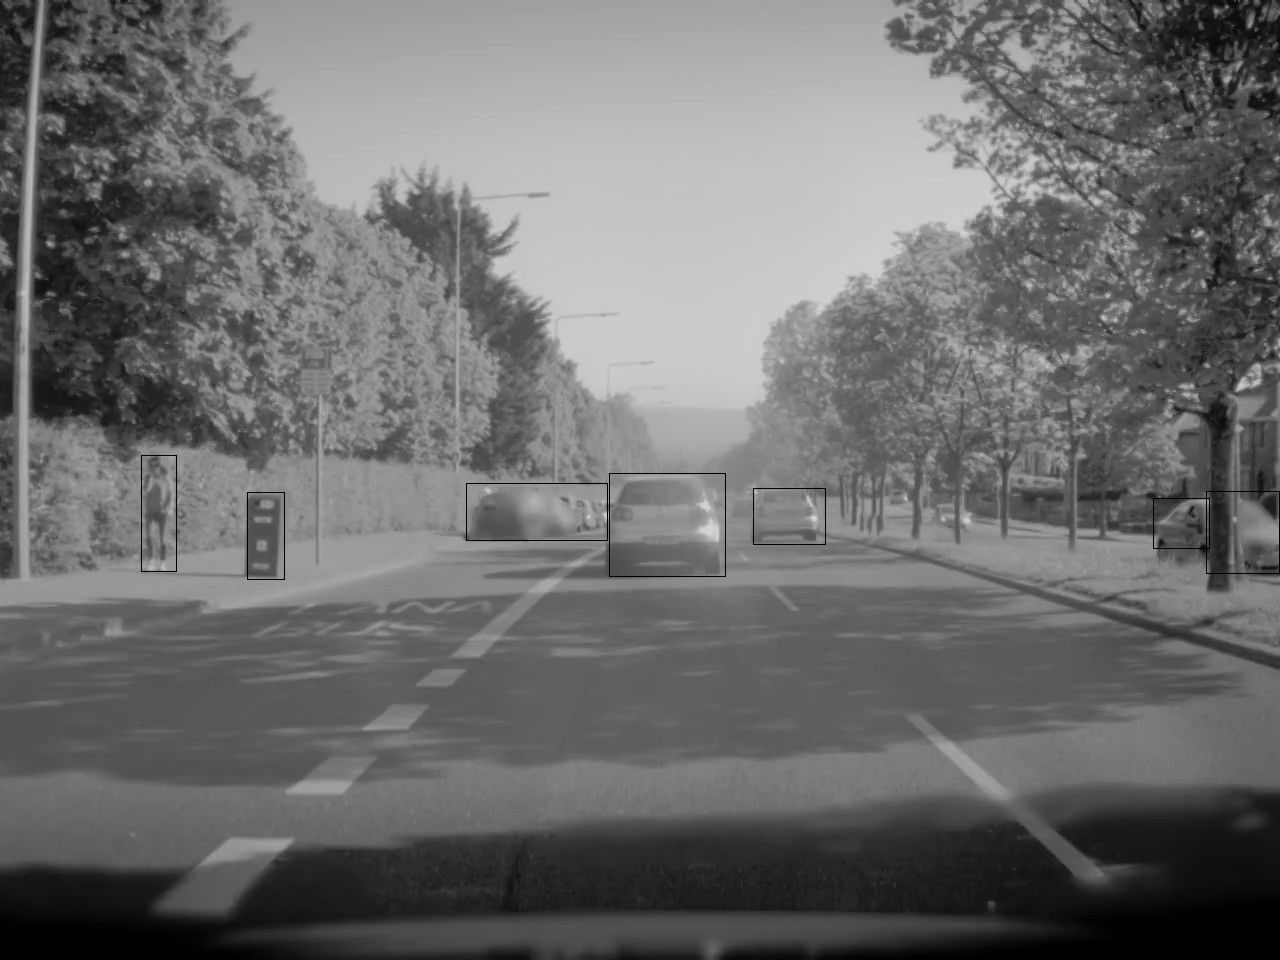

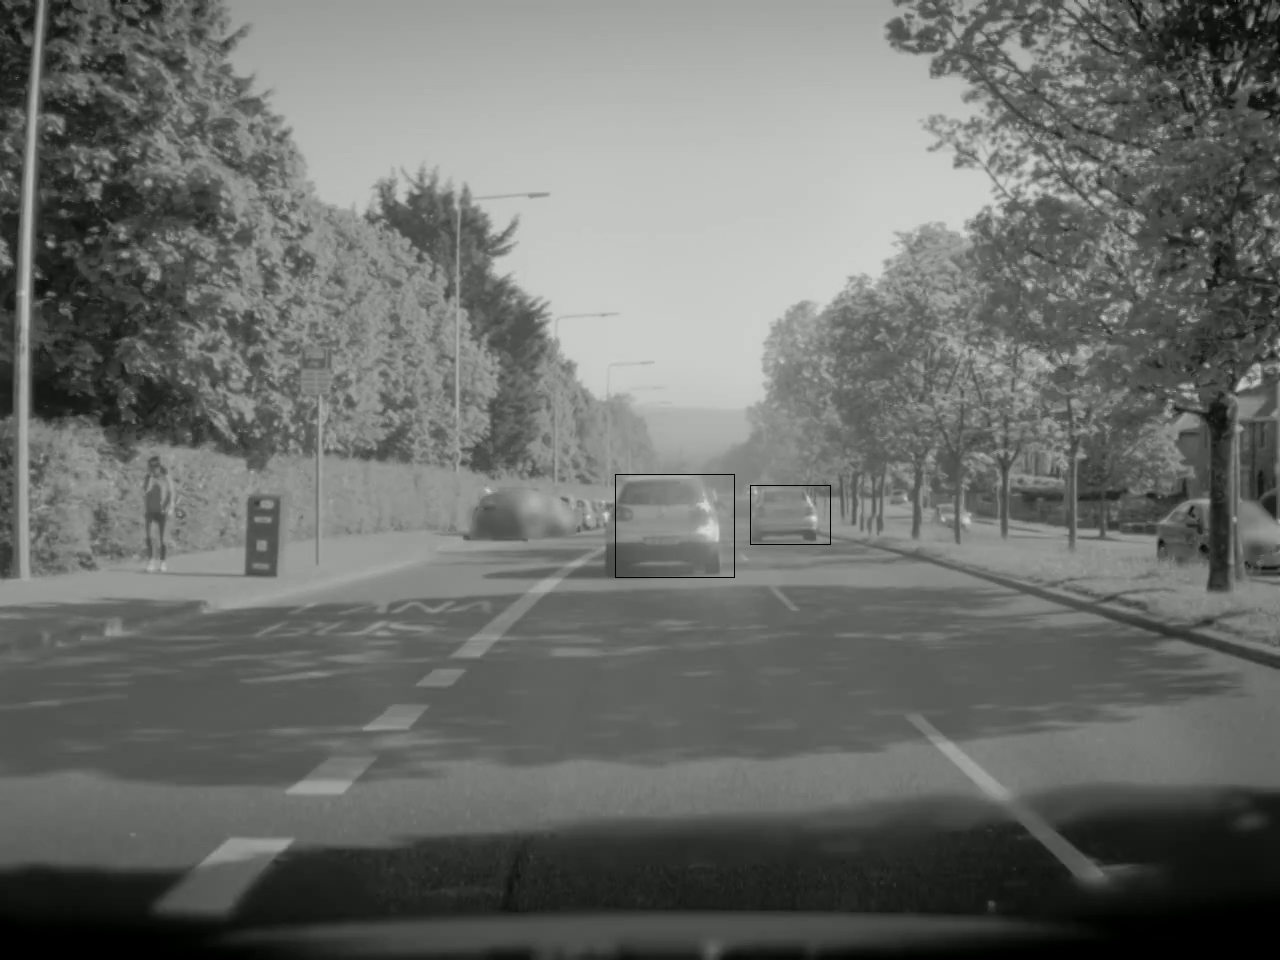

In [25]:
listImgFinal.foreach { image => Image(image.entriesIterator.toArray).withFormat(Image.PNG).withWidth(500).display }

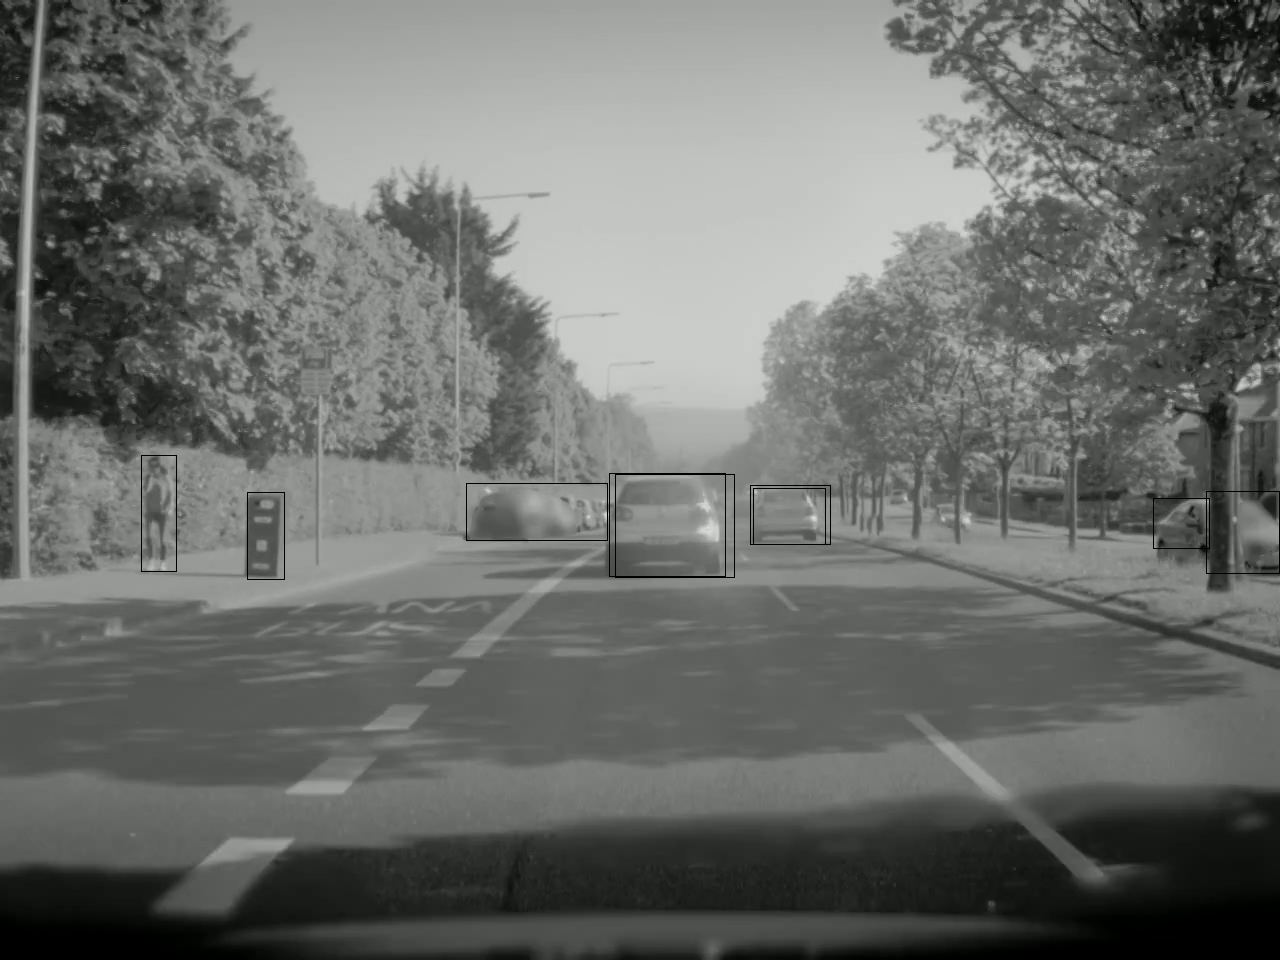

In [26]:
Image(imgFinalCombined.entriesIterator.toArray).withFormat(Image.PNG).withWidth(500).display

## Soft-NMS

In [27]:
// Group identification by class because Soft-NMS works for each class separately
val mapDetections = listTabBoxes.flatten.map { case(s, c, l) => (s, c, List(l(0)*height, l(1)*width, l(2)*height, l(3)*width)) }.groupBy { case(c, _, _) => c }
// Keep only car and person detections
var listBoxesCar = mapDetections("car").to[ListBuffer]
var listBoxesPerson = mapDetections("person").to[ListBuffer]

mapDetections: Map[String, List[(String, Float, List[Float])]] = Map(
  "car" -> List(
    ("car", 0.9794971F, List(473.81433F, 610.0625F, 577.3947F, 726.06384F)),
    ("car", 0.90885586F, List(483.8241F, 466.60205F, 540.65234F, 607.5811F)),
    ("car", 0.90802795F, List(489.02234F, 753.86646F, 545.3339F, 826.1106F)),
    ("car", 0.7555205F, List(498.54968F, 1154.1982F, 548.979F, 1210.1288F)),
    ("car", 0.52926576F, List(492.26657F, 1207.6356F, 573.75397F, 1280.0F)),
    ("car", 1.0F, List(474.70187F, 615.692F, 577.64246F, 735.1233F)),
    ("car", 0.99995637F, List(486.24326F, 751.39276F, 545.4293F, 831.3529F))
  ),
  "parking" -> List(
    ("parking", 0.42517924F, List(493.02585F, 247.19435F, 579.9822F, 284.3469F))
  ),
  "person" -> List(
    ("person", 0.95856625F, List(455.927F, 141.77826F, 572.51917F, 177.0967F))
  )
)
listBoxesCar: ListBuffer[(String, Float, List[Float])] = ListBuffer(
  ("car", 0.9794971F, List(473.81433F, 610.0625F, 577.3947F, 726.06384F)),
  ("car", 0.90885586F, List(483.8241F, 466.60205F, 540.65234F, 607.5811F)),
  ("car", 0.90802795F, List(489.02234F, 753.86646F, 545.3339F, 826.1106F)),
  ("car", 0.7555205F, List(498.54968F, 1154.1982F, 548.979F, 1210.1288F)),
  ("car", 0.52926576F, List(492.26657F, 1207.6356F, 573.75397F, 1280.0F)),
  ("car", 1.0F, List(474.70187F, 615.692F, 577.64246F, 735.1233F)),
  ("car", 0.99995637F, List(486.24326F, 751.39276F, 545.4293F, 831.3529F))
)
listBoxesPerson: ListBuffer[(String, Float, List[Float])] = ListBuffer(
  ("person", 0.95856625F, List(455.927F, 141.77826F, 572.51917F, 177.0967F))
)

## Implementation transformed into more functional way
Below this, you can find the python copied implementation

In [28]:
def softNMS(boxesWithScore: ListBuffer[(String, Float, List[Float])]): List[List[Float]] = {
    var listInitial = boxesWithScore.clone()
    var listFinalDetectionBoxes = ListBuffer[List[Float]]()
    
    while (listInitial.nonEmpty) {
        // Find box with the max score detection
        val maxBox = listInitial.maxBy(_._2)
        val List(ty1, tx1, ty2, tx2) = maxBox._3
        listFinalDetectionBoxes += listInitial.remove(listInitial.indexOf(maxBox))._3
        // Modify score in function of the shared area
        listInitial = listInitial.map {
            case (c, s, p) => 
                val area = (p(3) - p(1) + 1) * (p(2) - p(0) + 1)
                val iw = (min(tx2, p(3)) - max(tx1, p(1)) + 1)
                val ih = (min(ty2, p(2)) - max(ty1, p(0)) + 1)
                val scoreWeighted = 
                    if (iw > 0 && ih > 0) {
                        val ua = ((tx2 - tx1 + 1) * (ty2 - ty1 + 1) + area - iw * ih)
                        val ov = iw * ih / ua
                        s * exp(-(ov * ov) / sigma).toFloat
                    }
                    else s
                (c, scoreWeighted, p)
        }
        // Remove boxes in function of our threshold and their nms score
        listInitial = listInitial.filterNot(_._2 < threshold)
    }
    
    listFinalDetectionBoxes.toList
}

defined function softNMS

## Implementation copied from Python Code

## Display results

In [29]:
val nmsBoxes = softNMS(listBoxesCar).flatMap { case(List(y1,x1,y2,x2)) => List(y1/height, x1/width, y2/height, x2/width)}


nmsBoxes: List[Float] = List(
  0.49448112F,
  0.4810094F,
  0.6017109F,
  0.5743151F,
  0.5065034F,
  0.5870256F,
  0.5681555F,
  0.64949447F,
  0.50398344F,
  0.36453286F,
  0.56317955F,
  0.47467273F,
  0.5193226F,
  0.90171736F,
  0.5718531F,
  0.9454131F,
  0.5127777F,
  0.94346535F,
  0.59766036F,
  1.0F
)

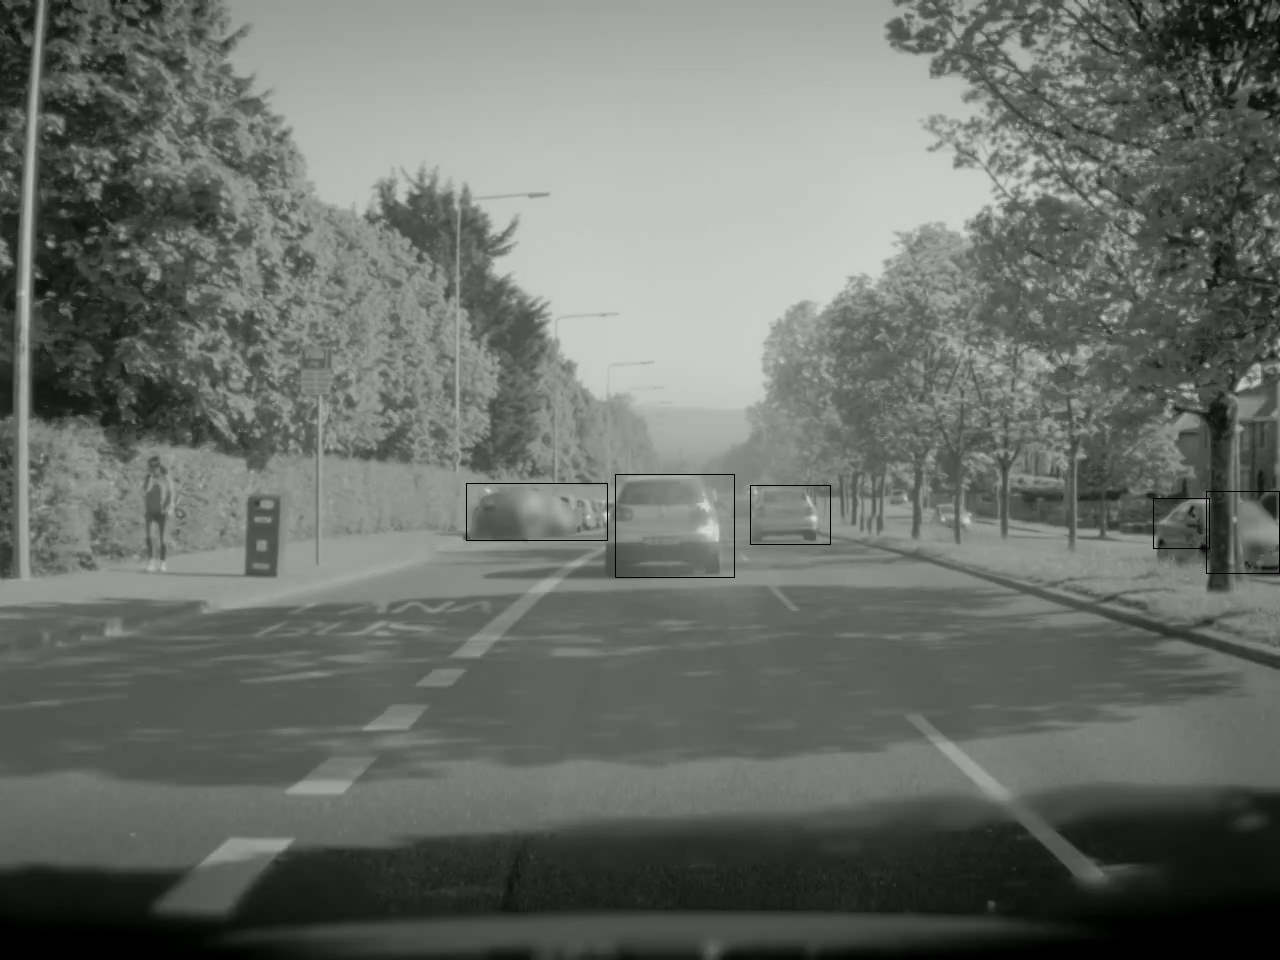

tensorNmsBoxes: Tensor[Float] = Tensor[Float, [1, 20]]
tensorReshapeNmsBoxes: org.platanios.tensorflow.api.ops.Output[Float] = Output(
  Reshape_6,
  0
)
imageCombinedNms: org.platanios.tensorflow.api.ops.Output[UByte] = Output(
  Reshape_7,
  0
)
imgFinalCombinedNms: Tensor[Byte] = Tensor[Byte, [595846]]

In [30]:
val tensorNmsBoxes = Tensor(nmsBoxes)
val tensorReshapeNmsBoxes = tf.reshape(tensorNmsBoxes, Shape(1, nmsBoxes.length / 4, 4))
val imageCombinedNms = tf.reshape(TImage.drawBoundingBoxes(imageOuts.slice(NewAxis, ---).toFloat, tensorReshapeNmsBoxes).toUByte, Shape(height, width, 3))
val imgFinalCombinedNms = tf.createWith() {
    val exampleImage = tf.decodeRaw[Byte](tf.image.encodePng(imageCombinedNms))
    sessionSimple.run(fetches = exampleImage)
}
Image(imgFinalCombinedNms.entriesIterator.toArray).withFormat(Image.PNG).withWidth(500).display
